In [1]:
import gymnasium as gym
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import random
import csv
import os
import pandas as pd

In [2]:
def log_results(results, filename, type_):
    # Define the headers for your CSV file

    if type_ == '1k_logs':
        headers = ['Mean Episodic Reward', 'Critic loss', 'Actor loss']  # Add your result names here

        # Open the CSV file in 'append' mode so that existing data isn't overwritten
        with open(filename, 'a', newline='') as csvfile:
            writer = csv.writer(csvfile)
            
            # Write headers if the file is empty
            if csvfile.tell() == 0:
                writer.writerow(headers)
            
            # Write the results to the CSV file
            writer.writerow(results)

    elif type_ == '20k_ep_rewards':
        headers = ['Mean episodic reward']  # Add your result names here

        # Open the CSV file in 'append' mode so that existing data isn't overwritten
        with open(filename, 'a', newline='') as csvfile:
            writer = csv.writer(csvfile)
            
            # Write headers if the file is empty
            if csvfile.tell() == 0:
                writer.writerow(headers)
            
            # Write the results to the CSV file
            writer.writerow(results)


In [3]:
class Actor(nn.Module):
    def __init__(self, state_dim, n_actions):
        super().__init__()

        self.model = nn.Sequential(
            
            nn.Linear(state_dim, 64),
            nn.Tanh(),
            nn.Linear(64,64),
            nn.Tanh(),
            nn.Linear(64,64),
            nn.Tanh(),
            nn.Linear(64,n_actions),
            nn.Softmax()
        )

    def forward(self,x):
        x = torch.Tensor(x)
        return self.model(x)

In [4]:
class Critic(nn.Module):
    def __init__(self, state_dim):
        super().__init__()

        self.model = nn.Sequential(
            nn.Linear(state_dim, 64),
            nn.Tanh(),
            nn.Linear(64,64),
            nn.Tanh(),
            nn.Linear(64,64),
            nn.Tanh(),
            nn.Linear(64,1)
        )

    def forward(self,x):
        x = torch.Tensor(x)
        return self.model(x)

In [5]:
class A2C_Agent(): #this should work with more parallel environment already, not the evaluate functions

    def __init__(self, n_envs, actor, critic, lr_actor, lr_critic):
        self.n_envs = n_envs
        self.actor = actor
        self.critic = critic
        self.actor_optimizer = torch.optim.Adam(actor.parameters(), lr=lr_actor)
        self.critic_optimizer = torch.optim.Adam(critic.parameters(), lr=lr_critic)
    

    def choose_action(self, states, action_type = "training"):        
        state_values = self.critic.forward(states)
        action_probs = self.actor.forward(states)
        

        if action_type == "training":
            actions_pd = torch.distributions.Categorical(probs=action_probs)
            actions = actions_pd.sample()
            actions_log_prog = actions_pd.log_prob(actions)
            return actions, actions_log_prog, state_values
        
        elif action_type == "greedy":
            actions = torch.argmax(action_probs) #greedy policy
            return actions, state_values
    
    def get_losses(self, rewards, states, next_states, log_prob, gamma, terminated):
        
        delta = torch.Tensor(rewards.reshape(self.n_envs,1)) + (1-torch.Tensor(terminated.reshape(self.n_envs,1))) * gamma * self.critic(next_states).detach()
        advantage = delta - self.critic(states)  

        critic_loss = advantage.pow(2).mean()
        
        actor_loss = - (advantage.detach() * log_prob.reshape_as(advantage.detach())).mean()

        return actor_loss, critic_loss
    
    def update_params(self, critic_loss, actor_loss):
        
        self.critic_optimizer.zero_grad()
        critic_loss.backward()
        self.critic_optimizer.step()

        self.actor_optimizer.zero_grad()
        actor_loss.backward()
        self.actor_optimizer.step()

    def evaluate_performance(self):
        
        episodic_rewards_10 = []
        v_values = []
        env = gym.make("CartPole-v1")
        for j in range(10):
            state, _ = env.reset()
            total_reward = 0
            done = False
            while not done:
                action, state_values = self.choose_action(state, action_type= "greedy")
                #get the current value function fro one trajectory (j==0)
                if j == 0 : v_values.append(state_values.detach().data.numpy()) #shitty with float
                
                #go to the next state
                next_state, reward, terminated, truncated, _  = env.step(action.detach().data.numpy())
                total_reward += reward
                state = next_state
                
                done = terminated or truncated
            episodic_rewards_10.append(total_reward)
        print("episodic return of the 20000:", np.mean(episodic_rewards_10))
        return np.mean(episodic_rewards_10), v_values
    
    def evaluate_training(self, total_rewards, actor_loss, critic_loss, filename, type_):

        avg_reward = 0

        for v in total_rewards:
            avg_reward += np.mean(v)
        
        avg_reward /= len(total_rewards)

        log_results([avg_reward, critic_loss.detach().data.numpy(), actor_loss.detach().data.numpy()], filename, type_)
    


In [6]:
def train(seed, filenames, n_envs=1, n_steps=1, sparse=False):
    v_values = []
    total_steps = 0
    max_steps = 500000

    np.random.seed(seed)

    env = gym.vector.AsyncVectorEnv([lambda:gym.make("CartPole-v1") for i in range(n_envs)])
    envs_wrapper = gym.wrappers.RecordEpisodeStatistics(env, deque_size=n_envs * max_steps)
    state_dim  = env.single_observation_space.shape[0]
    n_actions = env.single_action_space.n

    torch.manual_seed(seed)
    actor = Actor(state_dim, n_actions)
    critic = Critic(state_dim)
    agent = A2C_Agent(n_envs=n_envs, actor=actor, critic=critic, lr_actor=1e-5, lr_critic=1e-3)
    
    state = env.reset(seed=seed)[0]

    total_rewards = []
    for i in range(n_envs): total_rewards.append([])
    ep_reward = [0]*n_envs
    while total_steps < max_steps: 

        ## We don't need to reset the environment since we use AsyncEnv ##
        
        actions, actions_log_prog, _ = agent.choose_action(state)
        
        next_state, reward, terminated, truncated, _ = env.step(actions.numpy())

        for i in range(n_envs):
            ep_reward[i] += reward[i]
            if terminated[i] or truncated[i]:
                total_rewards[i].append(ep_reward[i])
                ep_reward[i] = 0
        
        reward_ = reward #use another varaible bc we mask only to the learner
        if sparse:
            r = []
            for i in range(n_envs):
                if reward[i] == 1.:
                    if np.random.uniform(0,1) < 0.9:
                        r.append(0.)
                    else:
                        r.append(1.)
                else: #if it's 0 it stays 0
                    r.append(0.)
            reward_ = np.array(r)

        actor_loss, critic_loss = agent.get_losses(reward_, state, next_state, actions_log_prog, 0.99, terminated)
    
        state = next_state

        agent.update_params(critic_loss, actor_loss)

        if (total_steps % 1000) == 0:
            agent.evaluate_training(total_rewards, actor_loss, critic_loss, filenames[0], "1k_logs")
            total_rewards = []
            for i in range(n_envs): total_rewards.append([])
        if (total_steps % 20000 == 0): 
            reward_20k, vs = agent.evaluate_performance()
            log_results([reward_20k], filenames[1], "20k_ep_rewards")
            vvs = []
            for v in vs:
                vvs.append(v[0])
            v_values.append(vvs)

        if total_steps >= max_steps:
            break  
        else: total_steps += 1
            
                                
    col_names = ['V_Values_'+str(i) for i in range(0,500001,20000)]
    series = []

    for name, v in zip(col_names, v_values): 
        serie = pd.Series(v, name=name)
        series.append(serie)
    
    df = pd.concat(series, axis=1)
    df.to_csv(filenames[2], index=False)

    return envs_wrapper

In [7]:
seeds = [42, 123, 3112]
ews = []
for seed in seeds:
    folder_name = 'testt2'
    if not os.path.exists(folder_name): os.makedirs(folder_name)

    filenames = [os.path.join(folder_name, str(seed)+'_1_1k.csv'), os.path.join(folder_name, str(seed)+'_1_20k_rewards.csv'), 
                 os.path.join(folder_name, str(seed)+'_1_20k_V_Values.csv')]

    e_w = train(seed, filenames, n_envs=6, sparse=True)
    ews.append(e_w)

/Users/thomasbrunet/opt/anaconda3/envs/rl_project/lib/python3.9/site-packages/torch/nn/modules/module.py:1511: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/Users/thomasbrunet/opt/anaconda3/envs/rl_project/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/thomasbrunet/opt/anaconda3/envs/rl_project/lib/python3.9/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


episodic return of the 20000: 9.8
episodic return of the 20000: 458.6
episodic return of the 20000: 136.4
episodic return of the 20000: 500.0
episodic return of the 20000: 447.8
episodic return of the 20000: 181.6
episodic return of the 20000: 308.3
episodic return of the 20000: 490.9
episodic return of the 20000: 94.8
episodic return of the 20000: 437.2
episodic return of the 20000: 444.1
episodic return of the 20000: 377.6
episodic return of the 20000: 246.5
episodic return of the 20000: 413.3
episodic return of the 20000: 105.8
episodic return of the 20000: 500.0
episodic return of the 20000: 500.0
episodic return of the 20000: 391.1
episodic return of the 20000: 84.6
episodic return of the 20000: 175.7
episodic return of the 20000: 500.0
episodic return of the 20000: 402.8
episodic return of the 20000: 185.2
episodic return of the 20000: 438.8
episodic return of the 20000: 42.7
episodic return of the 20000: 9.6
episodic return of the 20000: 500.0
episodic return of the 20000: 478.6

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt
                        
def plotting(folder_name, seeds):
    actors  = []
    critics = []
    rewards = []
    rewards_20 = []
    v_values = []
    v0 = []
    v1 = []
    v2 = []
    for i, seed in enumerate(seeds):

        filenames = [os.path.join(folder_name, str(seed)+'_1_1k.csv'), os.path.join(folder_name, str(seed)+'_1_20k_rewards.csv'), 
                 os.path.join(folder_name, str(seed)+'_1_20k_V_Values.csv')]
        data1 = pd.read_csv(filenames[0])
        actors.append(data1['Actor loss'])
        critics.append(data1['Critic loss'])
        rewards.append(data1['Mean Episodic Reward'])

        data2 = pd.read_csv(filenames[1])
        rewards_20.append(data2['Mean episodic reward'])

        data3 = pd.read_csv(filenames[2])

        if i==0:
            v0.append(data3['V_Values_20000'])  #not great but ok for now
            v1.append(data3['V_Values_60000'])
            v2.append(data3['V_Values_400000'])

        for col in data3.columns:
            v_values.append(data3[col])

    print(v2)
    mean_actors = np.mean(actors, axis=0)
    mean_critics = np.mean(critics, axis=0)
    mean_rewards = np.mean(rewards, axis=0)
    mean_rewards20 = np.mean(rewards_20, axis=0)
    mean_vs = np.mean(v_values, axis=0)

    max_actors = np.max(actors, axis=0)
    max_critics = np.max(critics, axis=0)
    max_rewards = np.max(rewards, axis=0)
    max_rewards20 = np.max(rewards_20, axis=0)

    min_actors = np.min(actors, axis=0)
    min_critics = np.min(critics, axis=0)
    min_rewards = np.min(rewards, axis=0)
    min_rewards20 = np.min(rewards_20, axis=0)

    plt.plot(range(len(mean_actors)), mean_actors, color='blue', label='Mean')
    plt.fill_between(range(len(mean_actors)), min_actors, max_actors, color='gray', alpha=0.3, label='Min-Max Range')

    plt.xlabel('Step * 1000')
    plt.ylabel('Actor loss')
    plt.legend()
    plt.savefig(os.path.join(folder_name, 'Actor.jpg'), dpi=300)

    plt.figure()
    plt.plot(range(len(mean_critics)), mean_critics, color='blue', label='Mean')
    plt.fill_between(range(len(mean_critics)), min_critics, max_critics, color='gray', alpha=0.3, label='Min-Max Range')

    plt.xlabel('Step * 1000')
    plt.ylabel('Critic loss')
    plt.legend()
    plt.savefig(os.path.join(folder_name, 'Critic.jpg'), dpi=300)


    plt.figure()
    plt.plot(range(len(mean_rewards)), mean_rewards, color='blue', label='Mean')
    plt.fill_between(range(len(mean_rewards)), min_rewards, max_rewards, color='gray', alpha=0.3, label='Min-Max Range')

    plt.xlabel('Step * 1000')
    plt.ylabel('Mean episodic reward')
    plt.legend()
    plt.savefig(os.path.join(folder_name, 'Rewards_1k.jpg'), dpi=300)


    plt.figure()
    plt.plot(range(len(mean_rewards20)), mean_rewards20, color='blue', label='Mean')
    plt.fill_between(range(len(mean_rewards20)), min_rewards20, max_rewards20, color='gray', alpha=0.3, label='Min-Max Range')

    plt.xlabel('Step * 20000')
    plt.ylabel('Mean episodic reward')
    plt.legend()
    plt.savefig(os.path.join(folder_name, 'Rewards_20k.jpg'), dpi=300)

    plt.figure()
    plt.plot(range(len(mean_vs)), mean_vs, color='blue', label='Mean')

    plt.xlabel('Step')
    plt.ylabel('Value function')
    plt.legend()
    plt.savefig(os.path.join(folder_name, 'V_Values.jpg'), dpi=300)

    plt.figure()
    plt.plot(range(len(v0[0])), (v0[0]))
    plt.xlabel('Step')
    plt.ylabel('Value function')
    plt.savefig(os.path.join(folder_name, 'V_Value20k.jpg'), dpi=300)

    plt.figure()
    plt.plot(range(len(v1[0])), (v1[0]))
    plt.xlabel('Step')
    plt.ylabel('Value function')
    plt.savefig(os.path.join(folder_name, 'V_Value60k.jpg'), dpi=300)

    plt.figure()
    plt.plot(range(len(v2[0])), (v2[0]))
    plt.xlabel('Step')
    plt.ylabel('Value function')
    plt.savefig(os.path.join(folder_name, 'V_Value500k.jpg'), dpi=300)

    

[0      6.885060
1      7.038030
2      7.064769
3      7.274050
4      7.368078
         ...   
495    7.627037
496    7.804072
497    7.900368
498    7.826178
499    7.927360
Name: V_Values_400000, Length: 500, dtype: float64]


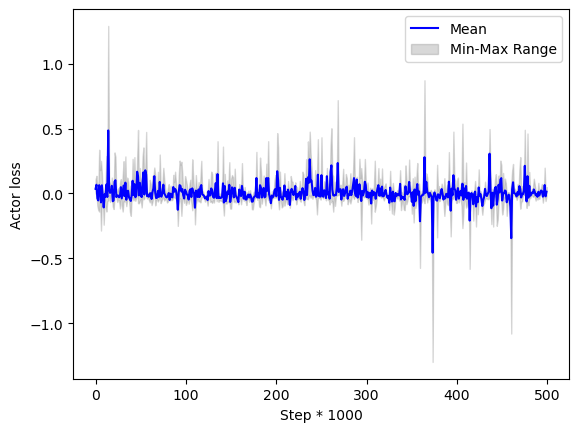

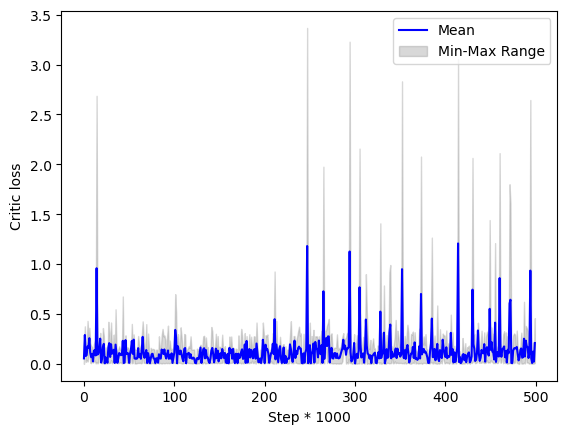

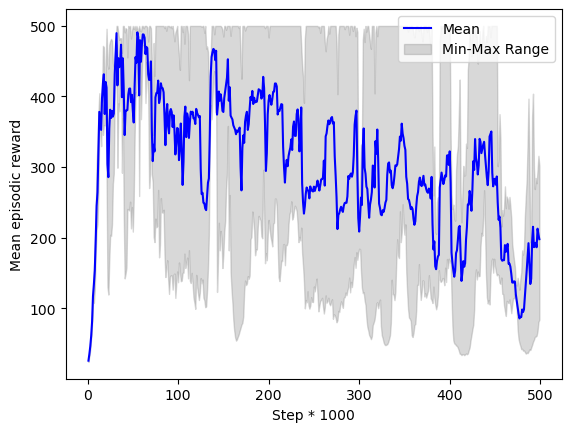

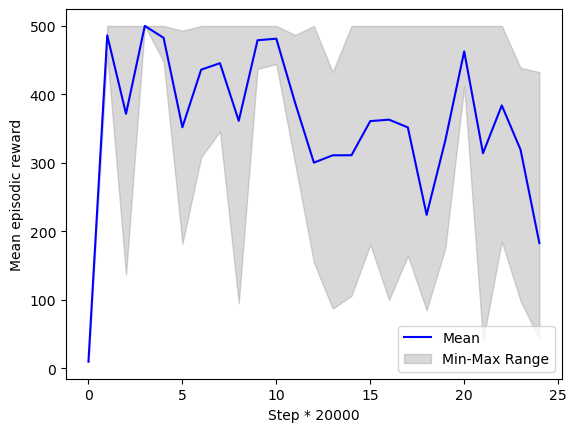

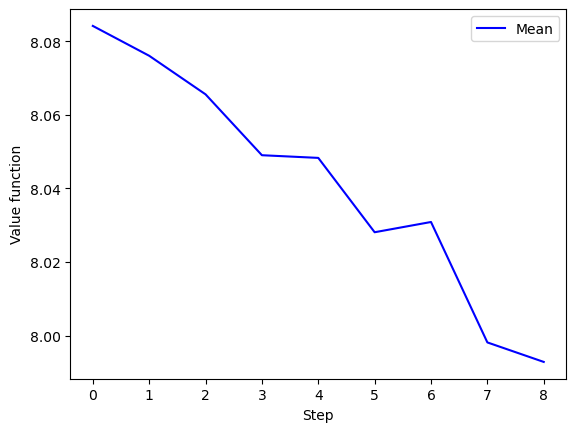

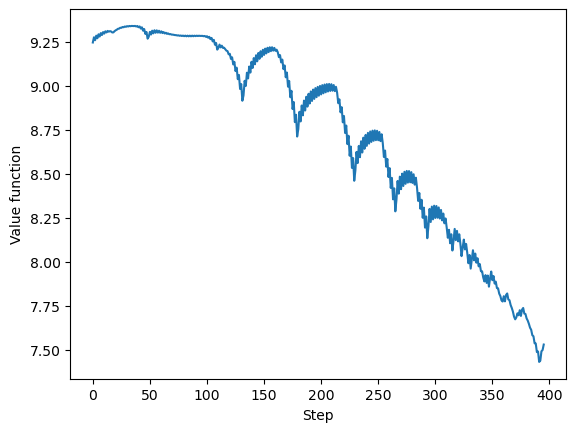

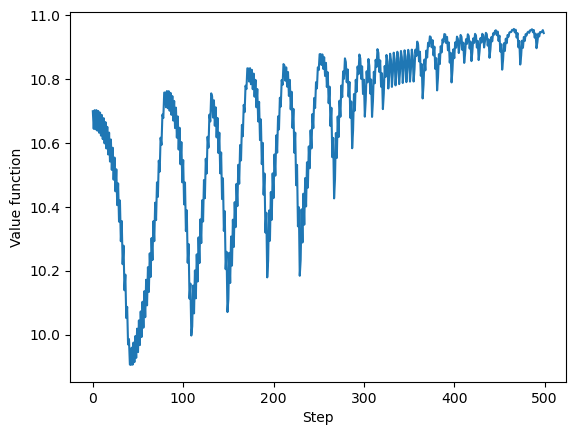

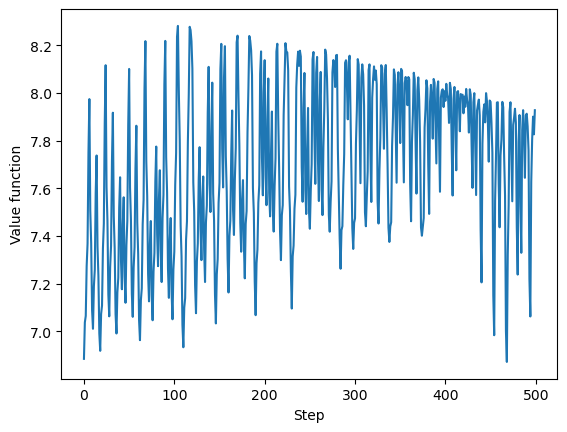

In [9]:
folder_name = 'testt2'
plotting(folder_name, seeds)